## Import Data
Import the modelnet40_ply_hdf5_2048 dataset and visiualize some samples

In [7]:
# Always reload in jupyter notebook
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from dgcnn.data import ModelNet40, load_data
from dgcnn.model import PointNet, DGCNN
from torch.utils.data import DataLoader
from dgcnn.util import cal_loss, IOStream
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
X_train, y_train = load_data('train')
X_test, y_test = load_data('test')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9840, 2048, 3) (9840, 1)
(2468, 2048, 3) (2468, 1)


Plot one sample

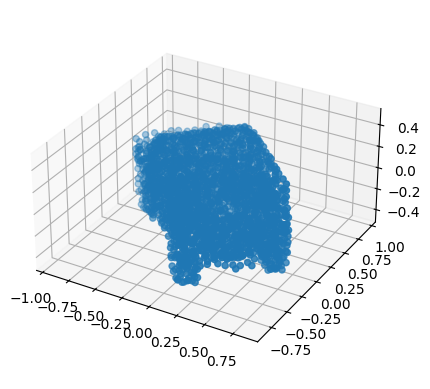

In [9]:
def plot_3d_shapes(X, y, ind):
    # Plot with the same scale for the axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[ind][:, 0], X[ind][:, 2], X[ind][:, 1])
    ax.set_aspect('equal', adjustable='box')
    plt.show()

plot_3d_shapes(X_train, y_train, 5)

## Training

Defining training functions

In [13]:
def init_experiment(exp_name):
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    if not os.path.exists('checkpoints/'+exp_name):
        os.makedirs('checkpoints/'+exp_name)
    if not os.path.exists('checkpoints/'+exp_name+'/'+'models'):
        os.makedirs('checkpoints/'+exp_name+'/'+'models')
    return IOStream('checkpoints/'+exp_name+'/run.log')

def train(exp_name, model, epochs, batch_size, test_batch_size, num_points, io, lr=0.001):
    train_loader = DataLoader(ModelNet40(partition='train', num_points=num_points), num_workers=8,
                              batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(ModelNet40(partition='test', num_points=num_points), num_workers=8,
                             batch_size=test_batch_size, shuffle=True, drop_last=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
        model = nn.DataParallel(model)
        io.cprint("Let's use " + str(torch.cuda.device_count()) + " GPUs.")
    else:
        io.cprint("Using CPU.")
    model.to(device)

    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(opt, epochs, eta_min=lr) 
    criterion = cal_loss

    best_test_acc = 0
    for epoch in range(epochs):
        ####################
        # Train
        ####################
        train_loss = 0.0
        count = 0.0
        model.train()
        train_pred = []
        train_true = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            opt.zero_grad()
            logits = model(data)
            loss = criterion(logits, label)
            loss.backward()
            opt.step()
            preds = logits.max(dim=1)[1]
            count += batch_size
            train_loss += loss.item() * batch_size
            train_true.append(label.cpu().numpy())
            train_pred.append(preds.detach().cpu().numpy())
        del data, label, logits, loss, preds
        torch.cuda.empty_cache()
        scheduler.step()
        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f' % (epoch,
                                                                                 train_loss*1.0/count,
                                                                                 metrics.accuracy_score(
                                                                                     train_true, train_pred),
                                                                                 metrics.balanced_accuracy_score(
                                                                                     train_true, train_pred))
        io.cprint(outstr)

        ####################
        # Test
        ####################
        test_loss = 0.0
        count = 0.0
        model.eval()
        test_pred = []
        test_true = []
        for data, label in test_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            logits = model(data)
            loss = criterion(logits, label)
            preds = logits.max(dim=1)[1]
            count += batch_size
            test_loss += loss.item() * batch_size
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
        del data, label, logits, loss, preds
        torch.cuda.empty_cache()
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        test_acc = metrics.accuracy_score(test_true, test_pred)
        avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
        outstr = 'Test %d, loss: %.6f, test acc: %.6f, test avg acc: %.6f' % (epoch,
                                                                              test_loss*1.0/count,
                                                                              test_acc,
                                                                              avg_per_class_acc)
        io.cprint(outstr)
        if test_acc >= best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'checkpoints/%s/models/model.t7' % exp_name)


def test(model, test_batch_size, num_points, io):
    test_loader = DataLoader(ModelNet40(partition='test', num_points=num_points),
                             batch_size=test_batch_size, shuffle=True, drop_last=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
        model = nn.DataParallel(model)
        io.cprint("Let's use " + str(torch.cuda.device_count()) + " GPUs.")
    else:
        io.cprint("Using CPU.")
    model.to(device)

    model = model.eval()
    test_acc = 0.0
    test_true = []
    test_pred = []
    for data, label in test_loader:
        data, label = data.to(device), label.to(device).squeeze()
        data = data.permute(0, 2, 1)
        logits = model(data)
        preds = logits.max(dim=1)[1]
        test_true.append(label.cpu().numpy())
        test_pred.append(preds.detach().cpu().numpy())
    del data, label, logits, preds
    torch.cuda.empty_cache()
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    test_acc = metrics.accuracy_score(test_true, test_pred)
    avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
    outstr = 'Test :: test acc: %.6f, test avg acc: %.6f'%(test_acc, avg_per_class_acc)
    io.cprint(outstr)

In [14]:
exp_name = 'dgcnn_1'
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
epochs = 2
batch_size = 8
test_batch_size = 8
num_points = 1024

io = init_experiment(exp_name)
train(exp_name, model, epochs, batch_size, test_batch_size, num_points, io)

Let's use 1 GPUs.
Train 0, loss: 2.554852, train acc: 0.500610, train avg acc: 0.318444
Test 0, loss: 2.083805, test acc: 0.675041, test avg acc: 0.560331
Train 1, loss: 2.108054, train acc: 0.683841, train avg acc: 0.526940
Test 1, loss: 1.794963, test acc: 0.815640, test avg acc: 0.683779


## Using pretrained model

In [15]:
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DataParallel(
  (module): DGCNN(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): 